##Introduction
In this notebook we demonstrate the Radiotherapy Outcomes Explorer (ROE)<sup>[1]</sup> tool for interactive exploration of tumor and normal tissue responses to changes in RT prescription dose.  

ROE is designed as a plugin to CERR and is available for download as a CERR module at https://github.com/cerr/CERR.git.

Here we use ROE to  demonstrates the effect of altering RT dose fraction size on predicted tumor control probability (TCP) and normal tissue complication probability (NTCP), demonstrating its potential for use in patient-specific prescription selectoion.

##Requirements
* GNU Octave with `io` and `statistics` packages for Debian/Linux (distributed via MSKCC Box).
* Python packages: `Oct2py` and `Octave_kernel` to run Octave functions, and `Matplotlib` for visualization
* ROE (distributed with [CERR](https://www.github.com/cerr/CERR.git))

See [installation instructions](https://github.com/stratis-forge/installation-and-dependencies) for different operating systems.

**Note**: Installing these tools may incur a one-time extra runtime overhead.

##I/O
Structures and dose plans are in CERR's native `planC` format (imported from DICOM). Sample dosimetric models and fractionation schemes used are distributed with ROE, in `JSON` format.

##Results
This notebook comes with a static visualization of sample dose-response plots.

## References
1. *Iyer, A., Jackson, A., Apte, A., Thor, M., & Deasy, J. (2017, June). ROE: Radiotherapy Outcomes Estimator-An Open-Source Tool for Modeling Radiotherapy Outcomes, Medical Physics, Vol. 44, No. 6, pp. 2885-2885.*

---

## Install dependencies
Uncomment (`Ctrl+/`) and run the cells below to install Octave with required packages, Oct2py, and CERR.

Octave and CERR can be saved to Google Drive to avoid downloading each time.

### Download latest Octave compile

In [0]:
# Locations of Octave and CERR
octave_path = '/content/octave'
cerr_path = '/content/CERR'

In [0]:
%%capture

# Download Octave
oct_build_box = 'https://mskcc.box.com/shared/static/ylfkha0p66oc8v5kh2z1qx9m13n0ijcx.gz'
oct_save_path = '/content/octave_7.3.0.tar.gz'
! wget {oct_build_box} -O {oct_save_path}
! tar xf {oct_save_path}
! rm {oct_save_path}

# Download CERR
! cd "$(dirname -- "$cerr_path")" && git clone --depth 1 --single-branch --branch octave_dev https://www.github.com/cerr/CERR.git

In [0]:
%%capture
# Download dependencies for Using Octave
! apt-get update
! cd /usr/lib/x86_64-linux-gnu/ && ln -s libhdf5_serial.so.103 libhdf5_serial.so.100 && ln -s libreadline.so.8 libreadline.so.7
! apt-get install libgraphicsmagick++-q16-12 libcholmod3 libcxsparse3 \
libumfpack5 libspqr2 libqrupdate1 libfftw3-3 libgfortran4 gnuplot openjdk-8-jdk

# Set path to Octave exectuable
import os, urllib.request, json
os.environ['OCTAVE_EXECUTABLE'] = octave_path + '/bin/octave-cli'
os.environ['PATH'] = octave_path + '/bin:' + os.environ['PATH']

# Install oct2py bridge for Python-Octave communication
! pip3 install octave_kernel
! pip3 install oct2py==5.6.0

# Enable Octave magic
%load_ext oct2py.ipython
from oct2py import octave

## ROE demo

In [0]:
%%capture
%%octave
pkg load statistics
pkg load io

### Prepare sample dataset

**Load sample dataset**

In [0]:
%%capture
%%octave

#Add CERR to path
cerrPath = '/content/CERR'
currDir = pwd;
cd(cerrPath)
addToPath2(cerrPath)
cd(currDir)

#Load test image
parts = strsplit(getCERRPath, filesep);
CERR_dir = strjoin(parts(1:end-2), filesep);
sampleData = fullfile(CERR_dir,['Unit_Testing/data_for_cerr_tests/',...
                      'CERR_plans/lung_ex1_20may03.mat.bz2']);
planC = loadPlanC(sampleData, tempdir);
planC = updatePlanFields(planC);
planC = quality_assure_planC(sampleData, planC);

**Rename/create required input structures**

In [0]:
%%capture
%%octave

indexS = planC{end};

#Rename GTV structure
strC = {planC{indexS.structures}.structureName};
GTVstrIdx = getMatchingIndex('GTV1',strC,'EXACT');
planC{indexS.structures}(GTVstrIdx).structureName = 'GTV';

#Create LUNG_GTV structure
lungStrIdx = getMatchingIndex('total_lung',strC,'EXACT');
planC = createDifferenceStructure(lungStrIdx,GTVstrIdx,planC);
planC{indexS.structures}(end).structureName = 'LUNG_GTV';

#Get list of available structures
strC = {planC{indexS.structures}.structureName};

**Visualize input structure masks and dose distribution**

In [0]:
%%octave
#Extract scan array
scanNum = 1;
CToffset = planC{indexS.scan}(scanNum).scanInfo(1).CTOffset;
scanArray = single(getScanArray(scanNum,planC)) - CToffset;

#Extract structure masks
numStructs = length(planC{indexS.structures});
structNameC = {planC{indexS.structures}.structureName};
strNameC = {'GTV', 'LUNG_GTV','Esophagus'};
for strNum = 1:length(strNameC)
    strx = strNameC{strNum};
    idx = getMatchingIndex(strx,structNameC,'EXACT');
    mask3M = getStrMask(idx, planC);
    maskC{strNum} = mask3M;
end

#Extract dose array
doseArray = getDoseArray(1,planC);

In [0]:
%octave_pull scanArray maskC doseArray

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import ipywidgets as widgets

dx, dy = 1, 1

x = np.arange(0, 255, dx)
y = np.arange(0, 255, dy)
extent = np.min(x), np.max(x), np.min(y), np.max(y)

cmaps = [plt.cm.Blues,plt.cm.Oranges,plt.cm.Greens]

clear_output(wait=True)

def window_image(image, window_center, window_width):
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    window_image = image.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max

    return window_image

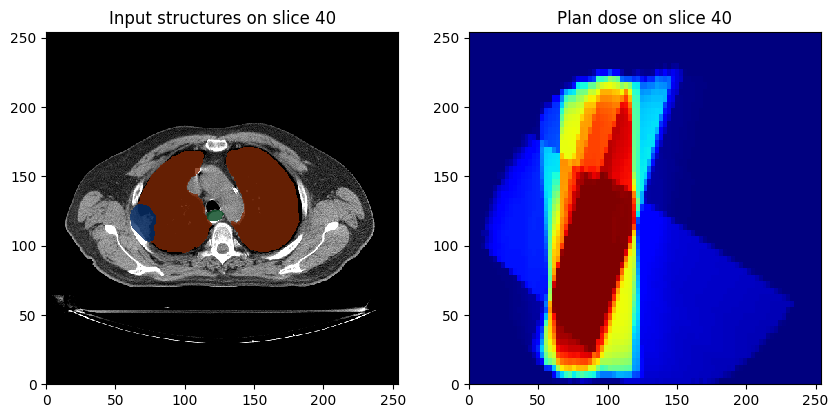

In [1]:
# Plot sample slice
scanSize = np.shape(scanArray)
slc = 40

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,10))

# Display scan with structure overlay
window_center = 40
window_width = 400

windowed_img = window_image(scanArray[:,:,slc],
                                window_center,window_width)
ax1.imshow(windowed_img, cmap=plt.cm.gray, alpha=1,
                    interpolation='nearest', extent=extent)
ax1.title.set_text('Input structures on slice ' + str(slc))
fontdict = {'fontsize' : 100}

# Display dose plan
for maskNum in range(0,3,1):
        mask_cmap = cmaps[maskNum]
        mask_cmap.set_under('k', alpha=0)
        im2 = ax1.imshow(maskC[0,maskNum][:,:,slc-1],
                        cmap=mask_cmap, alpha=.8, extent=extent,
                        interpolation='none', clim=[0.5, 1])

window_center = 40
window_width = 80

windowed_dose = window_image(doseArray[:,:,slc],
                                window_center,window_width)
ax2.imshow(windowed_dose, cmap=plt.cm.jet, alpha=1,
                    interpolation='nearest', extent=extent)
ax2.title.set_text('Plan dose on slice ' + str(slc))
fontdict = {'fontsize' : 100}

### Evaluate TCP/NTCP models

**Load model parameters**

In [0]:
%%capture
%%octave

protocoleDefPath = '/content/CERR/CERR_core/PlanAnalysis/sampleFilesForROE/Protocols/Lung 4Gyx15.json';
modelDefPath = '/content/CERR/CERR_core/PlanAnalysis/sampleFilesForROE/Models';

#Read JSON description of protocol
protocolInfoS = loadjson(protocoleDefPath); #fullfile(),protocolListC{protocolIdx(p)}));
modelListC = fieldnames(protocolInfoS.models);
#Get list of associated models
numModels = numel(modelListC);
protocolS.modelFiles = '';
for m = 1:numModels
        #Get path to JSON description of model
        modelFPath = fullfile(modelDefPath,protocolInfoS.models.(modelListC{m}).modelFile);
        #Load model parameters from JSON
        protocolS.model{m} = loadjson(modelFPath);
end
protocolS.numFractions = protocolInfoS.numFractions;
protocolS.totalDose = protocolInfoS.totalDose;

# Add BED model
modelFPath = [modelDefPath,filesep,'Lung BED.json'];
protocolS.model{numModels+1} = loadjson(modelFPath);
numModels = numModels+1;

**Scale dose plan to match user-input protocol**

In [0]:
%%capture
%%octave

#Scale dose plan
plnNum = 1;
prescribedDose = 80; #Test assuming 2Gy x 40
indexS = planC{end};

numFrxProtocol = protocolS.numFractions;
protDose = protocolS.totalDose;
dpfProtocol = protDose/numFrxProtocol;
dA = getDoseArray(plnNum,planC);
dAscale = protDose/prescribedDose;
dAscaled = dA * dAscale;

**Compute TCP & NTCPs at a range of dose scale factors**

In [0]:
%%capture
%%octave

TCPcount = 0;
NTCPcount = 0;
BEDcount = 0;
scaledTCPv = [];
scaledNTCPv = [];
scaledBEDv = [];
NTCPmodelListC = {};
TCPmodelListC = {};
BEDmodelListC = {};

#Loop over available models
for m = 1:numModels

        modelS = protocolS.model{m};

        #Get associated structure no.
        if ~isstruct(modelS.parameters.structures)
            #If model has no structure-specific parameters
            inputStruct = {modelS.parameters.structures};
        else
            inputStruct = fieldnames(modelS.parameters.structures);
        end
        strNum = getMatchingIndex(inputStruct, strC,'EXACT')

        #Read model parameters
        paramS = [modelS.parameters];
        paramS.numFractions.val = numFrxProtocol;
        paramS.frxSize.val = dpfProtocol;
        if isfield(modelS,'abRatio')
            abRatio = modelS.abRatio;
            paramS.abRatio.val = abRatio;
        end

        #Calc. DVH
        binWidth = 0.5;
        [dosesV,volsV] = getDVH(strNum,plnNum,planC);
        [doseBinsV,volHistV] = doseHist(dosesV,volsV,binWidth);

        # Scale dose bins by factors in [0.5,1.5] and compute corresponding TCP/NTCP
        xScaleV = linspace(0.5,1.5,99);
        scaledCPv = xScaleV * 0;

        if strcmp(modelS.type,'TCP')
             TCPcount = TCPcount + 1;
             TCPmodelListC{TCPcount} = modelS.name;
        elseif strcmp(modelS.type,'BED')
             BEDcount = BEDcount + 1;
             BEDmodelListC{BEDcount} = modelS.name;
        else
             NTCPcount = NTCPcount + 1;
             NTCPmodelListC{NTCPcount} = modelS.name;
        end

        #Loop over scale factors
        for n = 1 : numel(xScaleV)

                #Scale fraction size
                scale = xScaleV(n);
                paramS.frxSize.val = scale*dpfProtocol;

                #Scale dose bins
                scaledDoseBinsC = {scale * doseBinsV};

                #Fractionation correction to match modelled datset
                correctedScaledDoseC = frxCorrectROE(modelS,...
                    strNum,numFrxProtocol,scaledDoseBinsC);
                volHistC = {volHistV};

                #Calc. TCP/NTCP
                if strcmp(modelS.type,'TCP')
                    scaledTCPv(n,TCPcount) = feval(modelS.function,...
                        paramS,correctedScaledDoseC,volHistC);
                elseif strcmp(modelS.type,'BED')
                    scaledBEDv(n,BEDcount) = feval(modelS.function,...
                        paramS,correctedScaledDoseC,volHistC);
                else
                    scaledNTCPv(n,NTCPcount) = feval(modelS.function,...
                        paramS,correctedScaledDoseC,volHistC);
                end
        end


end

### Visualization

In [0]:
%octave_pull NTCPmodelListC TCPmodelListC BEDmodelListC dpfProtocol numFrxProtocol xScaleV scaledTCPv scaledNTCPv scaledBEDv

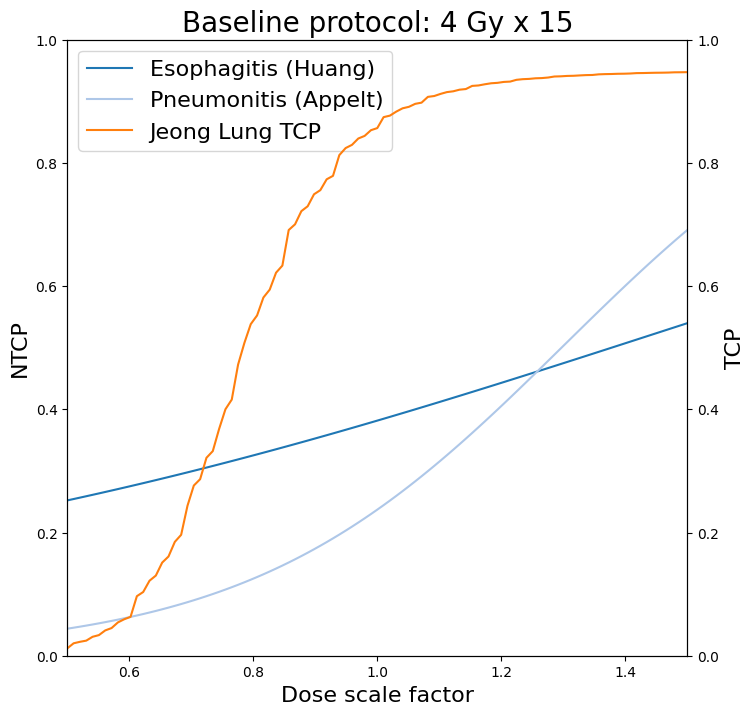

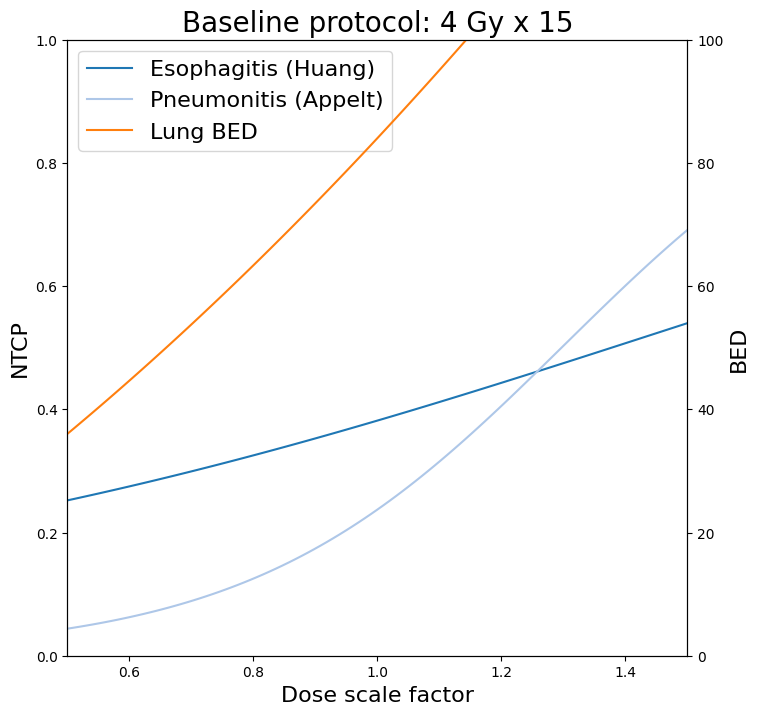

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import ipywidgets as widgets

def plotCurves(x,y1,y2,y2model,y2label,y2lim):

  colors = iter([plt.cm.tab20(i) for i in range(20)])

  # Create figure and axis objects
  fig = plt.figure(figsize=(8,8))
  ax = plt.axes()
  sizeV = np.shape(y1)

  # Plot normal tissue response curves
  x1labels = NTCPmodelListC[0]
  labels = list()
  for model in range(sizeV[1]):
    scaledPredV = y1[:,model]
    scaledPredV = np.reshape(scaledPredV,(sizeV[0],1))
    x = np.reshape(x,(sizeV[0],1))
    plt.plot(x,scaledPredV,color=next(colors),label=x1labels[model])
    labels.append(x1labels[model])

  ax.set_xlim(x[0],x[-1])
  ax.set_ylim(0,1)

  # Plot tumor response curve
  ax2=ax.twinx()
  ax2.set_xlim(x[0],x[-1])
  ax2.set_ylim(y2lim)
  scaledPredV = y2[:,0]
  ax2.plot(x,scaledPredV,color=next(colors),label=y2model)

  # Label axes
  ax.set_xlabel("Dose scale factor", fontsize = 16)
  ax.set_ylabel("NTCP",color="black",fontsize=16)
  ax2.set_ylabel(y2label,fontsize=16)

  # List models in legend
  h1, l1 = ax.get_legend_handles_labels()
  h2, l2 = ax2.get_legend_handles_labels()
  ax.legend(h1+h2, l1+l2, loc=2, fontsize=16)
  protocol = 'Baseline protocol: '+ str(int(dpfProtocol)) + \
  ' Gy x ' + str(int(numFrxProtocol))
  ax.set_title(protocol, fontsize=20)

  plt.show()

# Plot TCP, NTCP as a funcction of dose scale factor
plotCurves(xScaleV,scaledNTCPv,scaledTCPv,TCPmodelListC[0],'TCP',(0,1))
# Plot BED, NTCP as a funcction of dose scale factor
plotCurves(xScaleV,scaledNTCPv,scaledBEDv,BEDmodelListC[0],'BED',(0,100))
